In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
# Load the cleaned dataset
cleaned_movies = pd.read_csv("cleaned_movies.csv")

# Create dummy variables for genres
cleaned_movies['is_romance'] = (cleaned_movies['genre'] == 'Romance').astype(int)
cleaned_movies['is_action'] = (cleaned_movies['genre'] == 'Action').astype(int)

# Add interaction terms
#cleaned_movies['romance_runtime'] = cleaned_movies['is_romance'] * cleaned_movies['runtime']
#cleaned_movies['action_votes'] = cleaned_movies['is_action'] * cleaned_movies['runtime']

# Define features and target
# Include all relevant numeric and genre-related columns
X = cleaned_movies[['is_romance', 'is_action', 'runtime', 'votes', 'gross_earn', 'director_avg_earn']]
y = cleaned_movies['rating']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (important for Lasso regularization)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define Lasso model
lasso = Lasso(max_iter=10000)

# Define grid of alpha values (regularization strength)
alpha_grid = {'alpha': np.logspace(-3, 1, 50)}  # 50 values between 0.001 and 10

# Grid search with cross-validation
grid_search = GridSearchCV(lasso, param_grid=alpha_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best model
best_lasso = grid_search.best_estimator_

# Display the best alpha
print(f"Best alpha: {grid_search.best_params_['alpha']}")

# Predict on the test set
y_pred = best_lasso.predict(X_test_scaled)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

Best alpha: 0.0021209508879201904
RMSE: 0.8501802156554844
R²: 0.2572872275012905


In [12]:
cleaned_movies.shape

(5000, 16)

Best alpha: 0.0021209508879201904
RMSE: 0.8501802156554844
R²: 0.2572872275012905
Our model, with the specified alpha value, provides a moderate fit to the data. While the RMSE indicates reasonable accuracy, the R² suggests that there's still significant unexplained variance in the data, since it only explains about 25% of the data.

In [13]:
# Create a DataFrame to display coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_lasso.coef_
})

# Sort by absolute coefficient value
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

print(coefficients[['Feature', 'Coefficient']])


             Feature  Coefficient
3              votes     0.412315
2            runtime     0.266497
4         gross_earn    -0.159765
5  director_avg_earn    -0.065974
1          is_action    -0.013492
0         is_romance     0.000000


votes (0.412315): A one-unit increase in the number of votes is associated with a 0.412315 increase in the target variable, on average, holding other features constant.
runtime (0.266497): A one-unit increase in runtime is associated with a 0.266497 increase in the target variable, on average, holding other features constant.
gross_earn (-0.159765): A one-unit increase in gross earnings is associated with a 0.159765 decrease in the target variable, on average, holding other features constant.
director_avg_earn (-0.065974): A one-unit increase in the director's average earnings is associated with a 0.065974 decrease in the target variable, on average, holding other features constant.
is_action (-0.013492): If a movie is classified as an action movie (1), it is associated with a 0.013492 decrease in the target variable, compared to a non-action movie (0), holding other features constant.
is_romance (0.000000): This feature has no significant impact on the target variable.

In [14]:
#use shap to visual genre importance
import shap

# SHAP explainer for linear models
explainer = shap.Explainer(best_lasso, X_train_scaled)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_scaled)


c:\Users\bekah\miniconda3\envs\cs110\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


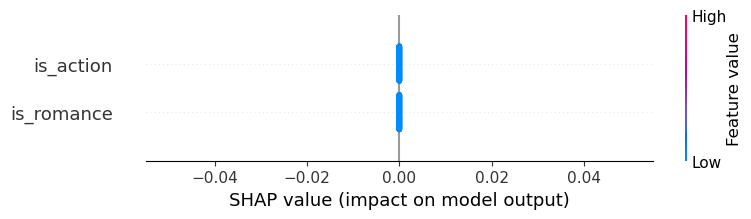

In [23]:
# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


The force plot shows that, for this particular prediction, the presence of the is_action and is_romance features led to a decrease in the model's output. This suggests that these features have a negative impact on the predicted value.

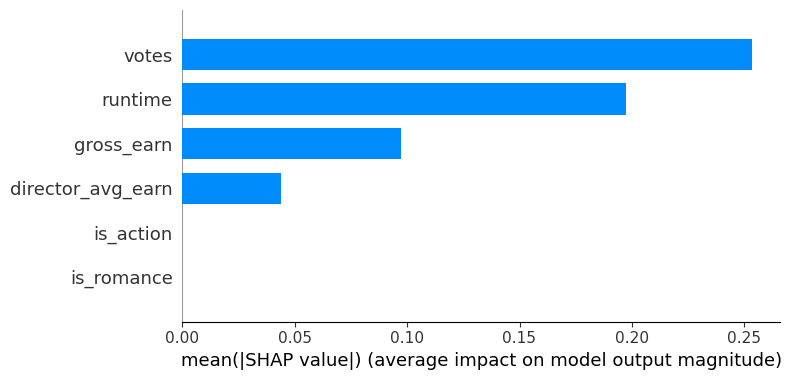

In [15]:
# Bar plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")


Votes and Runtime: These two features have the highest impact on the model's predictions. This suggests that movies with higher votes and longer runtimes tend to have higher predicted values.
Gross Earnings and Director's Average Earnings: These features also have a significant impact on the model's predictions, but to a lesser extent than votes and runtime.
Is_Action and Is_Romance: These features have the least impact on the model's predictions. This suggests that whether a movie is an action or romance movie has a relatively small influence on the predicted value.

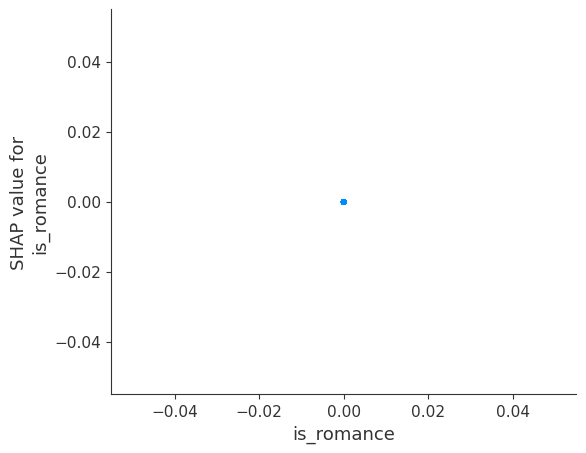

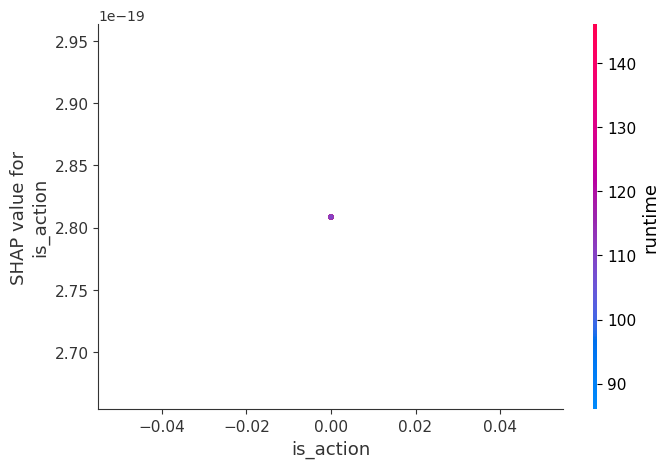

In [16]:
# Dependence plot for is_romance
shap.dependence_plot("is_romance", shap_values.values, X_test)

# Dependence plot for is_action
shap.dependence_plot("is_action", shap_values.values, X_test)


In [13]:
# Interaction plot between 'is_romance' and 'budget'
#shap.dependence_plot(("is_action", "gross_earn"), shap_values.values, X_test)
